In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models

In [2]:
df = pd.read_pickle('3Emociones.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4623 entries, 0 to 4622
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Imagen           4623 non-null   object
 1   Imagen con zoom  4623 non-null   object
 2   Hitos faciales   4623 non-null   object
 3   Etiquetas        4623 non-null   object
dtypes: object(4)
memory usage: 180.6+ KB


In [4]:
df.head()

,Imagen,Imagen con zoom,Hitos faciales,Etiquetas
0,"[[165, 166, 164, 167, 167, 166, 167, 167, 167,...","[[161, 160, 161, 161, 161, 161, 161, 160, 99, ...","[[62, 83], [62, 88], [63, 93], [63, 97], [64, ...",bored
1,"[[165, 166, 165, 166, 167, 167, 167, 167, 167,...","[[160, 161, 160, 161, 161, 162, 161, 162, 132,...","[[62, 83], [62, 88], [63, 93], [63, 97], [64, ...",bored
2,"[[165, 165, 165, 166, 167, 166, 166, 167, 167,...","[[160, 161, 161, 60, 36, 76, 88, 88, 92, 102, ...","[[63, 82], [63, 87], [63, 91], [63, 96], [65, ...",bored
3,"[[165, 166, 165, 165, 166, 167, 167, 167, 167,...","[[160, 161, 160, 45, 42, 81, 88, 88, 92, 101, ...","[[63, 83], [63, 87], [63, 92], [64, 97], [65, ...",bored
4,"[[165, 166, 166, 166, 166, 167, 166, 166, 167,...","[[160, 160, 160, 41, 43, 81, 88, 88, 92, 102, ...","[[63, 83], [63, 88], [63, 92], [64, 97], [65, ...",bored


In [5]:
print(df['Imagen con zoom'][0])

[[161 160 161 ... 130  26 169]
 [160 161 161 ...  86   8 164]
 [161 160 160 ...  41   5 108]
 ...
 [148 146 146 ... 159 159 160]
 [146 146 148 ... 159 158 160]
 [145 145 145 ... 155 157 158]]


In [6]:
import numpy as np
from PIL import Image

# Función para redimensionar una imagen
def redimensionar_imagen(imagen, nuevo_ancho, nuevo_alto):
    img = Image.fromarray(imagen)
    img = img.resize((nuevo_ancho, nuevo_alto))
    return np.array(img)

# Definir el tamaño al que quieres redimensionar todas las imágenes
nuevo_ancho = 150
nuevo_alto = 150

# Redimensionar todas las imágenes a la misma forma y convertirlas en arreglos numpy
X = np.array([redimensionar_imagen(imagen, nuevo_ancho, nuevo_alto) for imagen in df['Imagen con zoom']])


In [7]:
X = X /255.0

In [8]:
etiquetas = df['Etiquetas'].astype('category').cat.codes

In [9]:
print(etiquetas)

0       0
1       0
2       0
3       0
4       0
       ..
4618    2
4619    2
4620    2
4621    2
4622    2
Length: 4623, dtype: int8


In [10]:
#Dividir datos de entrenamiento y validacion

X_train, X_test, y_train, y_test = train_test_split(X, etiquetas, test_size=0.3, random_state=42)


In [11]:
# Definir el modelo CNN
model = models.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(nuevo_ancho, nuevo_alto, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(etiquetas), activation='softmax')
])

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 85:
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True
            
back = myCallback() 

In [13]:
#compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.fit(X_train, y_train,batch_size=10, epochs=25, validation_data=(X_test, y_test),callbacks=[back])

Epoch 1/25
324/324 [==============================] - 23s 68ms/step - loss: 0.9939 - accuracy: 0.5204 - val_loss: 0.7604 - val_accuracy: 0.6251
Epoch 2/25
324/324 [==============================] - 20s 62ms/step - loss: 0.6643 - accuracy: 0.6687 - val_loss: 0.6571 - val_accuracy: 0.6756
Epoch 3/25
324/324 [==============================] - 20s 62ms/step - loss: 0.5923 - accuracy: 0.7077 - val_loss: 0.5686 - val_accuracy: 0.7311
Epoch 4/25
324/324 [==============================] - 20s 62ms/step - loss: 0.5669 - accuracy: 0.7123 - val_loss: 0.6526 - val_accuracy: 0.6828
Epoch 5/25
324/324 [==============================] - 20s 62ms/step - loss: 0.5274 - accuracy: 0.7478 - val_loss: 0.5537 - val_accuracy: 0.7239
Epoch 6/25
324/324 [==============================] - 20s 62ms/step - loss: 0.4968 - accuracy: 0.7661 - val_loss: 0.5419 - val_accuracy: 0.7332
Epoch 7/25
324/324 [==============================] - 20s 62ms/step - loss: 0.4592 - accuracy: 0.7865 - val_loss: 0.5555 - val_accuracy:

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calcular la precisión del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Precisión del modelo en el conjunto de prueba:", test_accuracy)

# Generar la matriz de confusión
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

print("Matriz de confusión:")
print(confusion_mat)


44/44 [==============================] - 3s 75ms/step - loss: 1.6785 - accuracy: 0.7318
Precisión del modelo en el conjunto de prueba: 0.7317952513694763
44/44 [==============================] - 2s 54ms/step
Matriz de confusión:
[[278  13  15]
 [  9 385 219]
 [ 11 105 352]]


44/44 [==============================] - 2s 54ms/step


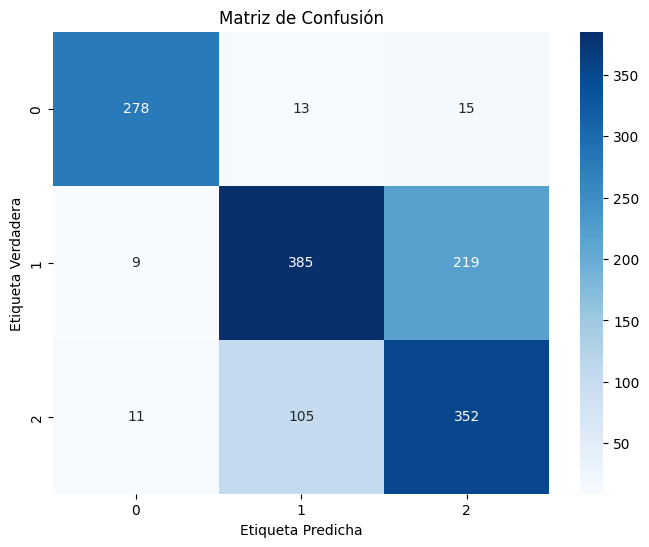

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

# Plotear la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()


In [21]:
import numpy as np
from PIL import Image

# Cargar y preprocesar la imagen
def cargar_y_preprocesar_imagen(ruta_imagen, nuevo_ancho, nuevo_alto):
    imagen = Image.open(ruta_imagen).convert('L')  # Convertir a escala de grises si es necesario
    imagen = imagen.resize((nuevo_ancho, nuevo_alto))
    imagen_array = np.array(imagen)
    imagen_array = np.expand_dims(imagen_array, axis=0)  # Agregar una dimensión de lote
    imagen_array = np.expand_dims(imagen_array, axis=3)  # Agregar una dimensión de canal (para escala de grises)
    return imagen_array

# Definir la ruta de la imagen a predecir
ruta_imagen = 'C:\\Users\\josek\\Desktop\Maestria\\SEMESTRE 2\\TOPICOS DE IA\\CORPUS\\bored\\222.jpeg'

# Cargar y preprocesar la imagen
imagen_array = cargar_y_preprocesar_imagen(ruta_imagen, 150, 150)

# Realizar la predicción
prediccion = model.predict(imagen_array)

# Obtener la clase predicha
clase_predicha = np.argmax(prediccion)

# Imprimir la clase predicha
print("Clase predicha:", clase_predicha)

1/1 [==============================] - 0s 23ms/step
Clase predicha: 1


In [22]:
model.save('affective_CNN_trainned_7318acc_3emotions.h5')